In [ ]:
!pip install numpy pandas tensorflow

In [ ]:
import numpy as np
import pandas as pd
import re
import pickle
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW

# Loading data
This notebook is using the **Sentiment140** dataset provided by **Kaggle**.
It contains 1.6M Tweets, labelled with 0 (negative) or 4 (positive).

Firstly, I dropped all the useless columns, by keeping only the target column and the text.

A preprocessing function is used to remove useless characters, tags or URLs.

In [ ]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1', header=None)

In [ ]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df.drop(columns=['id', 'date', 'flag', 'user', 'id'], inplace=True)

In [ ]:
def clean_tweet(tweet):
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)  # Remove @mentions
    tweet = re.sub(r'https?://[A-Za-z0-9./]+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove special characters
    tweet = tweet.lower()  # Convert to lowercase
    return tweet

In [ ]:
df['processed_text'] = df['text'].apply(clean_tweet)
df['target'] = df['target'].map({0: 0, 4: 1})

In [ ]:
vocab_size = 50000
max_length = 100

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['processed_text'])

In [ ]:
# Convert text to sequences and pad
sequences = tokenizer.texts_to_sequences(df['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# GloVe embeddings
I decided not to train embeddings from scratch, but rather to use GloVe embeddings, already pretrained and well-performing.

The version used is the `glove.6b` using 100 dimensions.

In [ ]:
def load_glove_embeddings(glove_path, embedding_dim, tokenizer, vocab_size):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.word_index.items():
        if index < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_dim = 100
glove_path = '/kaggle/input/glove100/glove.6B.100d.txt'

In [ ]:
embedding_matrix = load_glove_embeddings(glove_path, embedding_dim, tokenizer, vocab_size)

# Model
Once embeddings have been loaded, I moved to the model.
It is composed by the following layers:
1. **Embedding**: the GloVe embeddings loaded previously
2. **Bidirectional LSTM layers**: to give more context to the algorithm and make it consider the full sentence for making predictions
3. **Dense layers with Dropout**: to avoid overfitting by reducing complexity

In [ ]:
model = Sequential()

model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

# Model Training
Training stopped after 11 epochs due to the `EarlyStopping` introduced to prevent model's overfitting.

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    verbose=2,
    callbacks=[early_stopping])

Epoch 1/100
5000/5000 - 273s - 55ms/step - accuracy: 0.7883 - loss: 0.4500 - val_accuracy: 0.8087 - val_loss: 0.4138
Epoch 2/100
5000/5000 - 265s - 53ms/step - accuracy: 0.8185 - loss: 0.4004 - val_accuracy: 0.8171 - val_loss: 0.3995
Epoch 3/100
5000/5000 - 266s - 53ms/step - accuracy: 0.8283 - loss: 0.3820 - val_accuracy: 0.8251 - val_loss: 0.3865
Epoch 4/100
5000/5000 - 267s - 53ms/step - accuracy: 0.8359 - loss: 0.3683 - val_accuracy: 0.8268 - val_loss: 0.3837
Epoch 5/100
5000/5000 - 266s - 53ms/step - accuracy: 0.8418 - loss: 0.3566 - val_accuracy: 0.8272 - val_loss: 0.3830
Epoch 6/100
5000/5000 - 265s - 53ms/step - accuracy: 0.8476 - loss: 0.3456 - val_accuracy: 0.8271 - val_loss: 0.3824
Epoch 7/100
5000/5000 - 266s - 53ms/step - accuracy: 0.8531 - loss: 0.3351 - val_accuracy: 0.8281 - val_loss: 0.3840
Epoch 8/100
5000/5000 - 267s - 53ms/step - accuracy: 0.8580 - loss: 0.3246 - val_accuracy: 0.8243 - val_loss: 0.3957
Epoch 9/100
5000/5000 - 266s - 53ms/step - accuracy: 0.8631 - lo

# Data plotting
By looking at the chart below we can clearly see how validation performance was starting a downside trend, that would have lead to worse performance.
The accuracy reached is 87.0% for training and 82.2% for validation.
On the other hand, loss is 0.3 for accuracy, while 0.82 for validation.

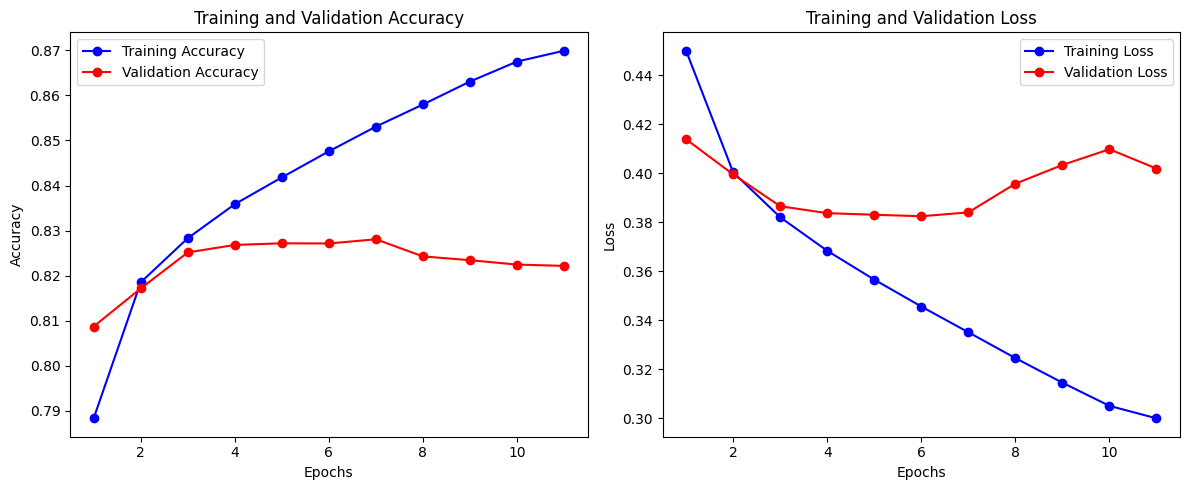

In [ ]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history.history

# Extract accuracy and loss for both training and validation
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(accuracy) + 1)

# Create two subplots: one for accuracy and one for loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Saving the model
After training I saved the model to have the possibility to use it later without repeating the training.
In addition, tokenizer, embeddings and configuration are saved.

In [ ]:
# 1. Model
model.save('sentiment_model_v2.h5')

# 2. Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. GloVe embedding matrix
np.save('glove_embedding_matrix.npy', embedding_matrix)

# 4. Configuration
config = {
    'max_sequence_length': max_length,
    'padding_strategy': 'post',
    'truncating_strategy': 'post',
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
}

with open('model_config.json', 'w') as f:
    json.dump(config, f)

print("Model and associated components saved successfully.")

Model and associated components saved successfully.


# Streamlit interface
In the same project you can also find a streamlit page using the model, that let you use the model to predict sentiment.
Feel free to use it, but do not expect astonishing performance.